In [2]:
import networkx as nx
%matplotlib notebook
import matplotlib.pyplot as plt

from ml_metadata.proto import metadata_store_pb2

In [2]:
# Import shared utils.
%run 'mlmd_utils.ipynb'

In [4]:
# Setup a read-only connection to the ML-Metadata store.
store = get_metadata_store(
    filename_uri=basedir+"/data/tfx/pipelines/chicago_taxi_pipeline_local/metadata.db",
    connection_mode=metadata_store_pb2.SqliteMetadataSourceConfig.READONLY)

In [5]:
def _find_upstream_executions(artifact_id):
    """Returns a list of upstream execution ids."""
    result = []
    for e in store.get_events_by_artifact_ids([artifact_id]):
        if e.type in [metadata_store_pb2.Event.DECLARED_OUTPUT, metadata_store_pb2.Event.OUTPUT]:
            result.append(e.execution_id)
    return result

def _find_upstream_artifacts(execution_id):
    """Returns a list of upstream artifact ids."""
    result = []
    for e in store.get_events_by_execution_ids([execution_id]):
        if e.type in [metadata_store_pb2.Event.DECLARED_INPUT, metadata_store_pb2.Event.INPUT]:
            result.append(e.artifact_id)
    return result

def _add_node_attribute(g, node_id, depth, is_artifact):
    # if it is not an artifact, use negative gnode id
    gnode_id = node_id if is_artifact else -1 * node_id
    g.add_node(gnode_id, depth=depth, is_artifact=is_artifact)
    node_label = "" #str(node_id) + "\n"
    if is_artifact:
        [a] = store.get_artifacts_by_id([node_id])
        [t] = store.get_artifact_types_by_id([a.type_id])
        node_label += t.name
    else:
        [e] = store.get_executions_by_id([node_id])
        [t] = store.get_execution_types_by_id([e.type_id])
        node_label += t.name
    g.nodes[gnode_id]['_label_'] = node_label

def _add_parents(g, node_id, is_artifact, depth, max_depth=None):
    # if it is not an artifact, use negative gnode id
    gnode_id = node_id if is_artifact else -1 * node_id
    _add_node_attribute(g, node_id, depth, is_artifact)
    if gnode_id in g and len(g.in_edges(gnode_id)) > 0: 
        return
    if max_depth is not None and depth > max_depth:
        return
    if is_artifact:
        for e_id in _find_upstream_executions(node_id):
            g.add_edge(e_id * -1, node_id)
            _add_parents(g, e_id, not is_artifact, depth + 1, max_depth)
    else:
        for a_id in _find_upstream_artifacts(node_id):
            g.add_edge(a_id, node_id * -1)
            _add_parents(g, a_id, not is_artifact, depth + 1, max_depth)

def _construct_artifact_lineage(artifact_id, max_depth=None):
    """Returns a networkx DiGraph representing the lineage of the given artifact_id."""
    g = nx.DiGraph(query_artifact_id=artifact_id)
    if max_depth is None or max_depth > 0:
        _add_parents(g, artifact_id, True, 1, max_depth)
    return g

In [6]:
def get_artifact_lineage(artifact_id, max_depth=None):
    """Returns lineage of artifact_id as a DAG.
       DAG is a networkx DiGraph
    """
    return _construct_artifact_lineage(artifact_id, max_depth)

def plot_artifact_lineage(g):
    """Use networkx and matplotlib to plot the graph.
       The nodes are places from left to right w.r.t. its depth.
       Nodes at the same depths are placed vertically.
       Artifact is shown in green, and Execution is shown in red.
       Nodes are positioned in a bipartite graph layout. 
    """
    # make a copy of the graph; add auxilary nodes
    dag = g.copy(as_view=False)
    label_anchor_id = 10000
    for node_id in g.nodes:
        if node_id > 0:
            dag.add_node(label_anchor_id + node_id)
        else:
            dag.add_node(node_id - label_anchor_id)

    # assign node color and label
    node_color = ""
    node_labels = {}
    for node_id in dag.nodes:
        if node_id > 0 and node_id < label_anchor_id:
            node_color += 'c' 
            node_labels[node_id] = abs(node_id)
        elif node_id > 0 and node_id >= label_anchor_id:
            node_color += 'w'
            node_labels[node_id] = dag.node[node_id - label_anchor_id]['_label_']
        elif node_id < 0 and node_id > -1 * label_anchor_id:
            node_color += 'm'
            node_labels[node_id] = abs(node_id)
        else:
            node_color += 'w'
            node_labels[node_id] = dag.node[node_id + label_anchor_id]['_label_']                
        
    pos = {}
    a_nodes = []; e_nodes = []
    for node_id in dag.nodes:
        if node_id > 0 and node_id < label_anchor_id:
            a_nodes.append(node_id)
        elif node_id < 0 and node_id > -1 * label_anchor_id:
            e_nodes.append(node_id)
            
    def order_nodes_by_depth(node_id):
        return -1 * dag.node[node_id]['depth'] + 1.0/node_id
            
    a_nodes.sort(key = abs)
    e_nodes.sort(key = abs) 
    a_node_y = 0
    e_node_y = 0.035
    a_offset = -0.5 if len(a_nodes) % 2 == 0 else 0
    e_offset = -0.5 if len(e_nodes) % 2 == 0 else 0
    a_node_x_min = -1 * len(a_nodes)/2 + a_offset
    e_node_x_min = -1 * len(e_nodes)/2 + e_offset
    a_node_x = a_node_x_min
    e_node_x = e_node_x_min
    node_step = 1
    for a_id in a_nodes:
        pos[a_id] = [a_node_x, a_node_y]
        pos[a_id + label_anchor_id] = [a_node_x, a_node_y - 0.01]
        a_node_x += node_step
    for e_id in e_nodes:
        pos[e_id] = [e_node_x, e_node_y]
        pos[e_id - label_anchor_id] = [e_node_x, e_node_y + 0.01]
        e_node_x += node_step

    #ax = plt.gca()
    nx.draw(dag, pos=pos,
            node_size=500, node_color=node_color, 
            labels=node_labels, node_shape = 'o', font_size=8.3, label="abc")#, ax=ax)
    
    #legend_x = (a_node_x_min + a_node_x + e_node_x_min + e_node_x - node_step * 2)/4.0
    #legend_y = -0.02
    legend_x = max(a_node_x, e_node_x) - 0.85
    legend_y = 0.02
    a_bbox_props = dict(boxstyle="square,pad=0.3", fc="c", ec="b", lw=0)
    plt.text(legend_x - 0.0025, legend_y, "  Artifacts  ", bbox=a_bbox_props)
    e_bbox_props = dict(boxstyle="square,pad=0.3", fc="m", ec="b", lw=0)
    plt.text(legend_x - 0.0025, legend_y - 0.007, "Executions", bbox=e_bbox_props)

    x_lim_left = min(a_node_x_min, e_node_x_min) - 0.5
    x_lim_right = min(1 - 0.05 * len(a_nodes), max(a_node_x, e_node_x))
    
    x_lim_left = max(-2 - 1.5/len(a_nodes), min(a_node_x_min, e_node_x_min) - 1.0)
    x_lim_right = max(a_node_x, e_node_x) + 0.1
    plt.xlim(x_lim_left, x_lim_right)
    
    plt.show()
    
dag = get_artifact_lineage(12)
plot_artifact_lineage(dag)

NameError: global name 'nx' is not defined

<IPython.core.display.Javascript object>


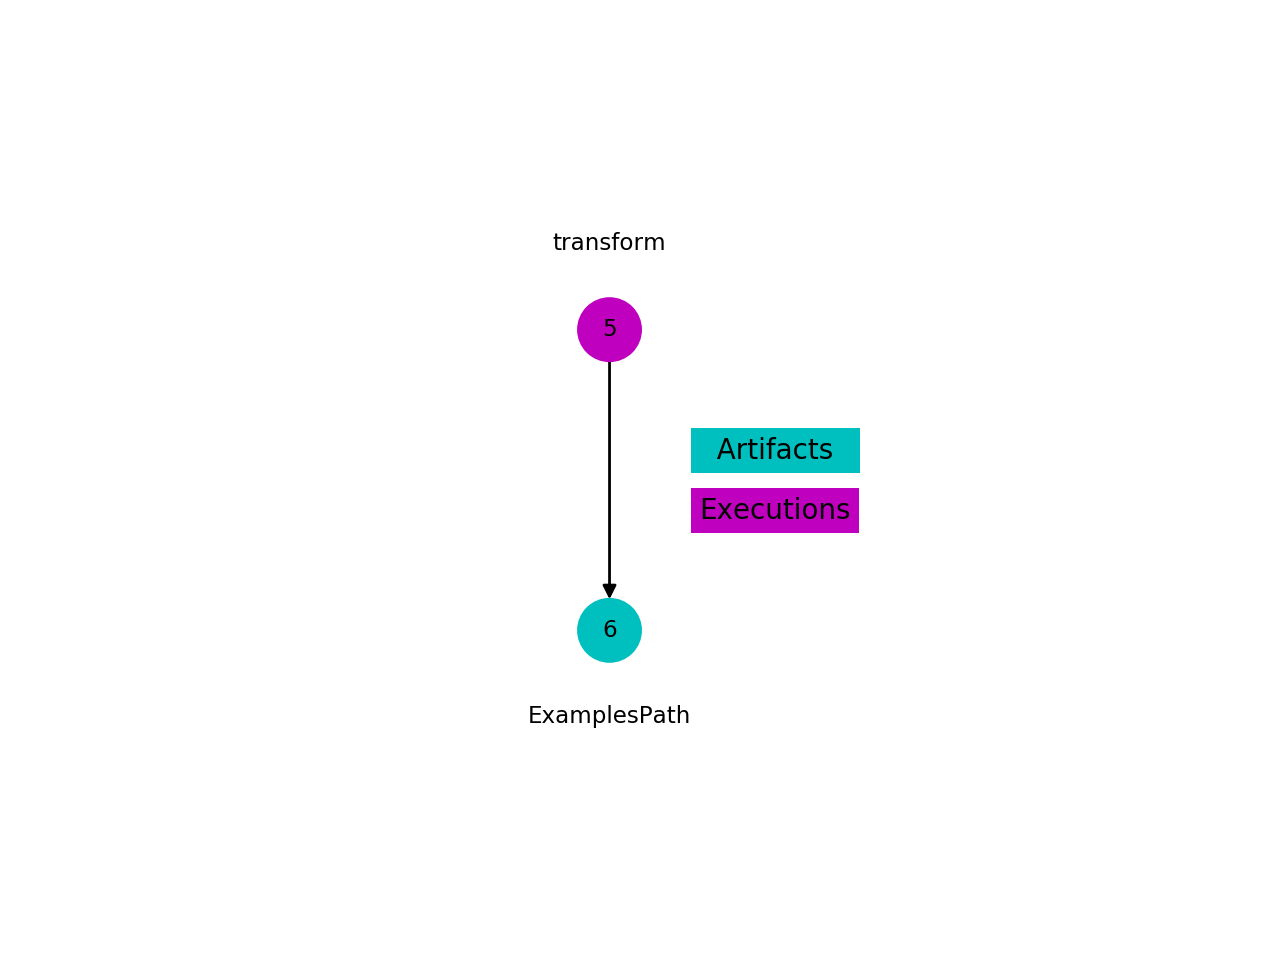

In [284]:
dag = get_artifact_lineage(6, 1)
plot_artifact_lineage(dag)

<IPython.core.display.Javascript object>


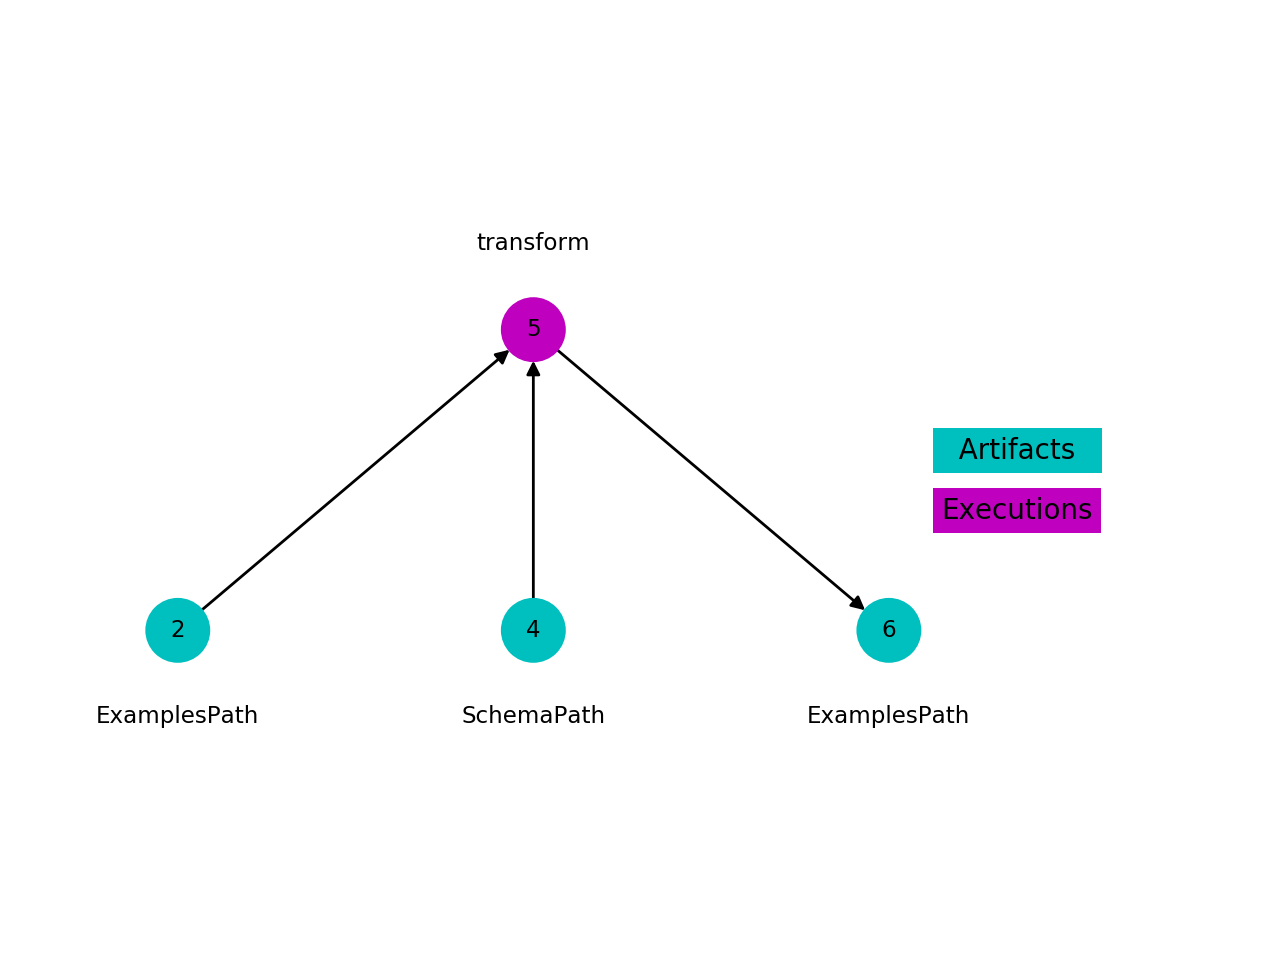

In [285]:
dag = get_artifact_lineage(6, 2)
plot_artifact_lineage(dag)

<IPython.core.display.Javascript object>


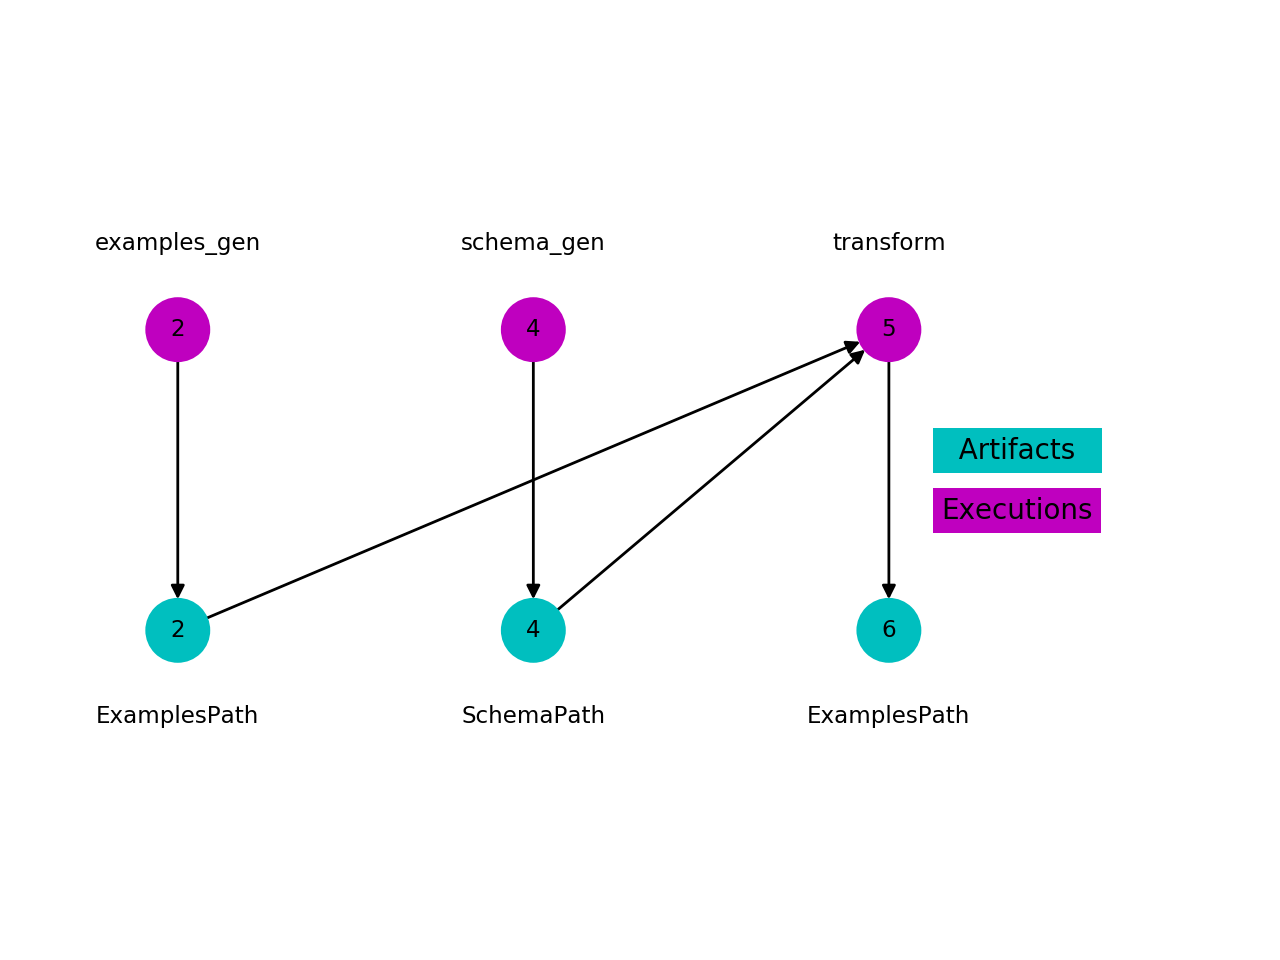

In [286]:
dag = get_artifact_lineage(6, 3)
plot_artifact_lineage(dag)

<IPython.core.display.Javascript object>


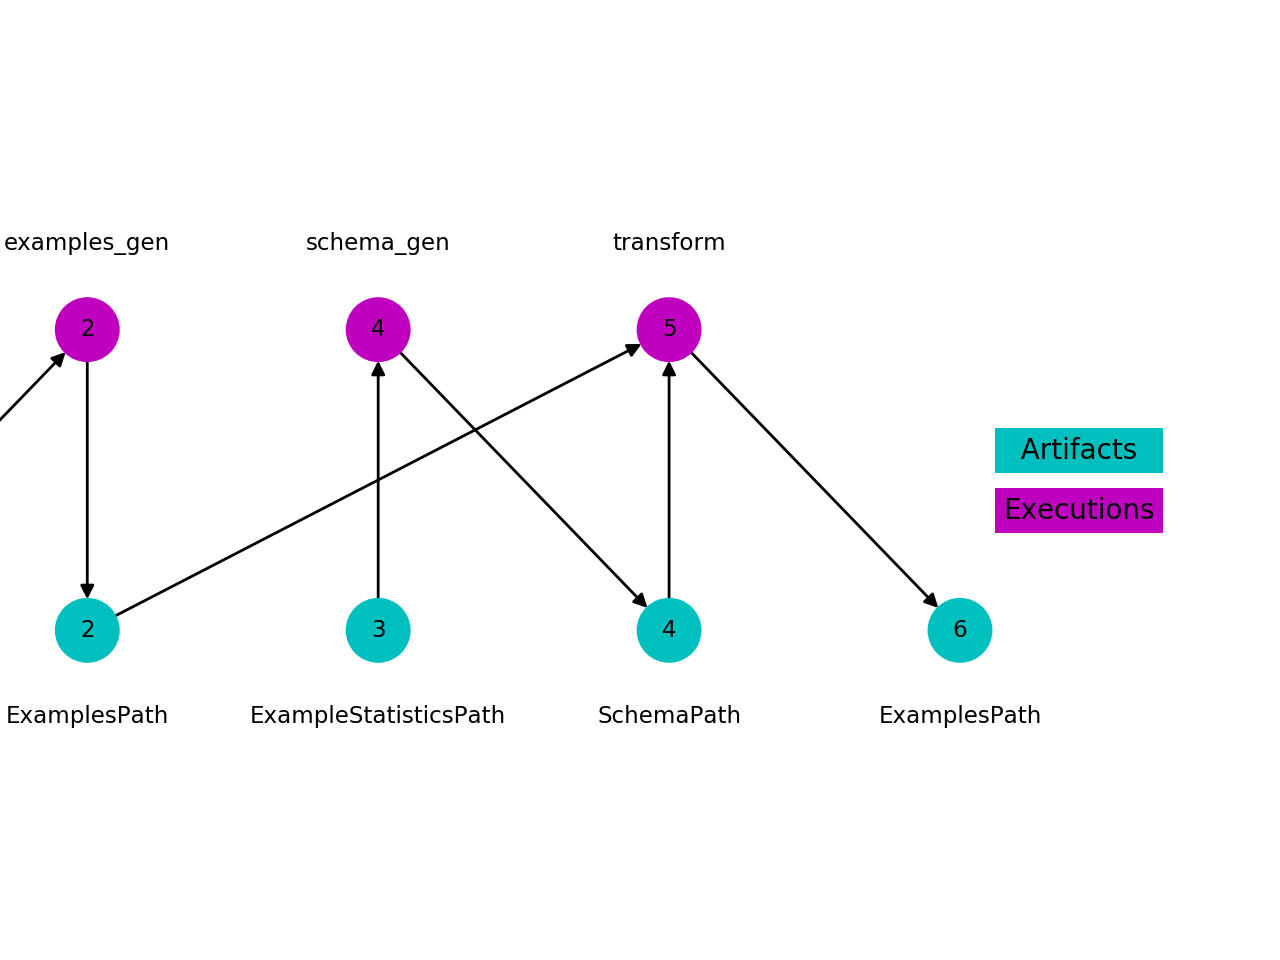

In [287]:
dag = get_artifact_lineage(6, 4)
plot_artifact_lineage(dag)

<IPython.core.display.Javascript object>


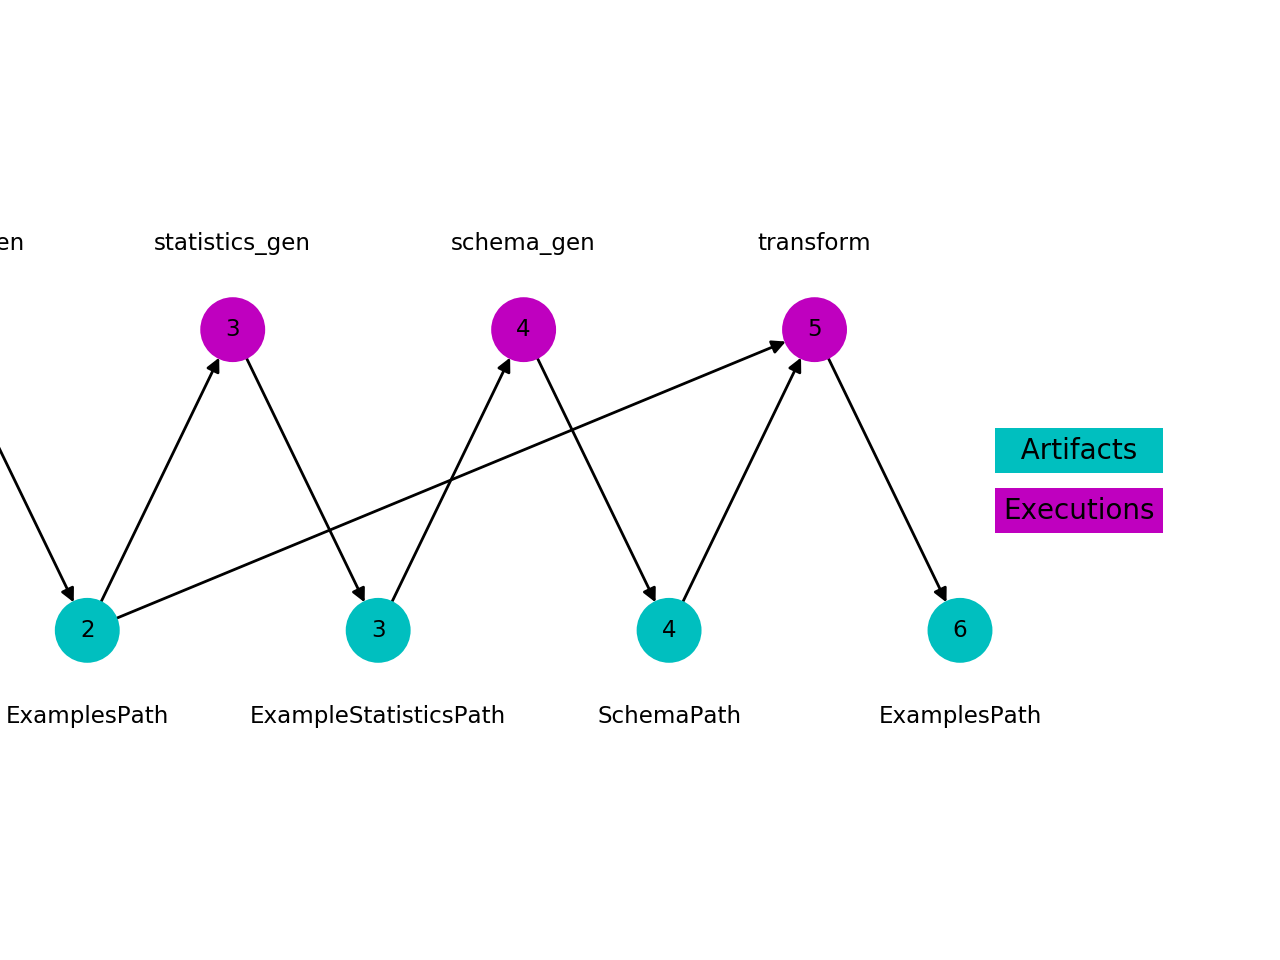

In [288]:
dag = get_artifact_lineage(6, 6)
plot_artifact_lineage(dag)